In [139]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [140]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/01-programming-for-everybody/VADER-programming-for-everybody.csv')

In [141]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999988169641919}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062,pos
1,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.9999984011655625}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678,pos
2,2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999980645444568}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703,pos
3,3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999973332745635}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448,pos
4,4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999967444537561}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,pos


In [142]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [143]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos
...,...,...,...,...,...,...,...,...
9558,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos
9559,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos
9560,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
9561,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [144]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [145]:
# Drop null values

# df.dropna(inplace = True)

In [146]:
# Check for null values

# len(df[df['review'].isna()==True])

In [147]:
# Reset the index

# df = df.reset_index(drop = True)

In [148]:
# df

In [149]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

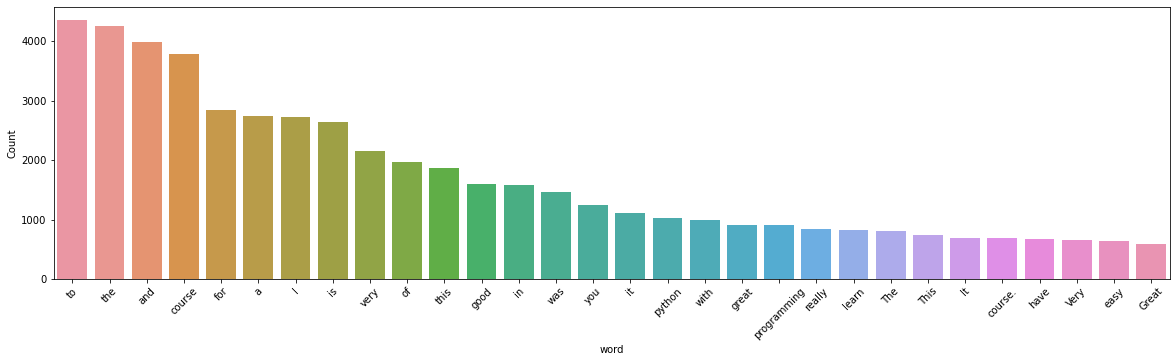

In [150]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [226]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course! definitely a very nice introdu...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [227]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course definitely a very nice introduc...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [228]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'one', 'well', 'thank', 'love', 'im', 'get'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head(10)

0    course beginners enjoy learn dr chuck made hug...
1    super easy totally beginners course title prof...
2          interactive course start programming pyhton
3    awesome course definitely introduction coding ...
4                                 perfect new learners
5    amazing course beginnersit beginner friendly c...
6                               course amazing teacher
7    challenging perfect course beginner python awe...
8                           programming using language
9                                            best best
Name: preprocessed, dtype: object

In [229]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score


In [230]:
df = df[(df['preprocessed']!= "")]

In [231]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score


In [232]:
# Build a model for creating bigrams

# bigram = gensim.models.Phrases(texts)

# df['preprocessed'] = [bigram[line] for line in df['preprocessed']]
# df['preprocessed'].head(5)

In [233]:
# Check for null values

# len(df[df['preprocessed'].isna()==True])

In [234]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

In [235]:
# Join reviews

# df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

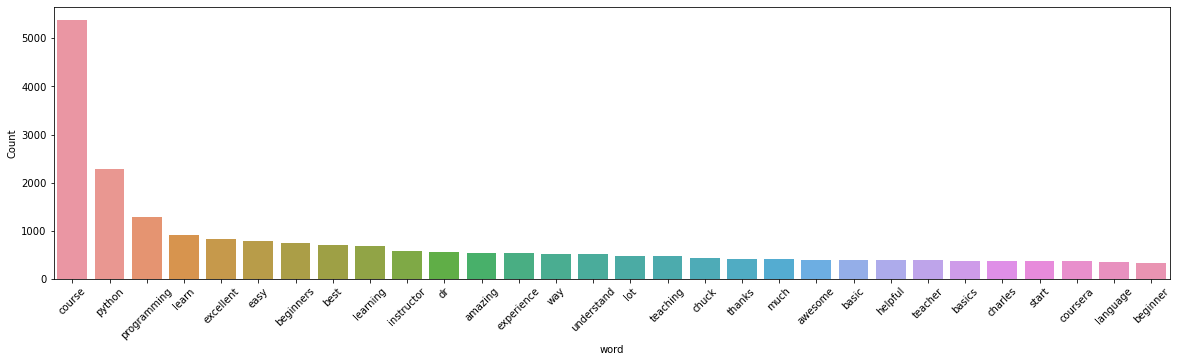

In [236]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [237]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, beginners, enjoy, learn, dr, chuck, m...
1    [super, easy, totally, beginners, course, titl...
2    [interactive, course, start, programming, pyhton]
3    [awesome, course, definitely, introduction, co...
4                             [perfect, new, learners]
Name: preprocessed, dtype: object

In [238]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (beginners, NNS), (enjoy, VBP),...
1    [(super, JJ), (easy, JJ), (totally, RB), (begi...
2    [(interactive, JJ), (course, NN), (start, NN),...
3    [(awesome, JJ), (course, NN), (definitely, RB)...
4          [(perfect, JJ), (new, JJ), (learners, NNS)]
Name: preprocessed, dtype: object

In [239]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [240]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (beginners, n), (enjoy, v), (lea...
1    [(super, a), (easy, a), (totally, r), (beginne...
2    [(interactive, a), (course, n), (start, n), (p...
3    [(awesome, a), (course, n), (definitely, r), (...
4              [(perfect, a), (new, a), (learners, n)]
Name: preprocessed, dtype: object

In [241]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, beginner, enjoy, learn, dr, chuck, ma...
1    [super, easy, totally, beginner, course, title...
2        [interactive, course, start, program, pyhton]
3    [awesome, course, definitely, introduction, co...
4                              [perfect, new, learner]
Name: preprocessed, dtype: object

In [242]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

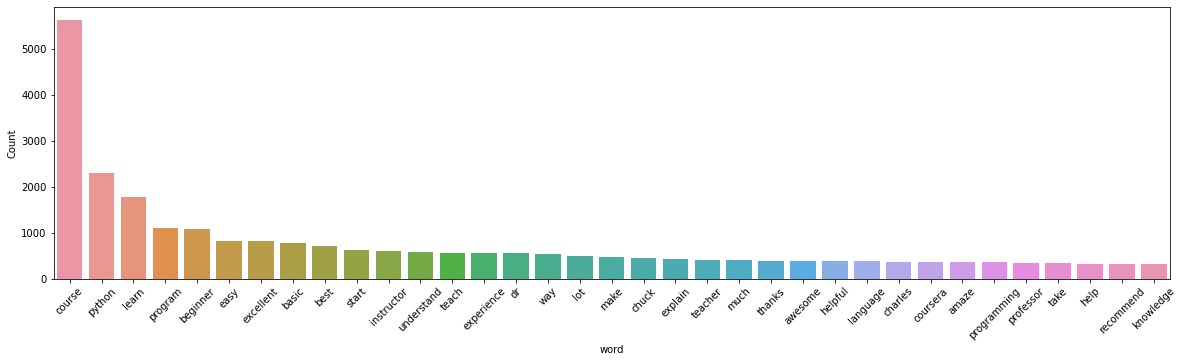

In [243]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

In [244]:
# Reset the index

df = df.reset_index(drop = True)

In [245]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",course beginner enjoy learn dr chuck make huge...,"(3, 0.39015016)",3.0,0.390150
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",super easy totally beginner course title profe...,"(2, 0.47463694)",2.0,0.474637
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",interactive course start program pyhton,"(3, 0.6914852)",3.0,0.691485
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",awesome course definitely introduction cod wor...,"(3, 0.748026)",3.0,0.748026
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",perfect new learner,"(0, 0.8054586)",0.0,0.805459
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos,"[excellent, explanation, start, computer, gene...",excellent explanation start computer general w...,"(3, 0.49895638)",3.0,0.498956
8828,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos,"[friend, recommanded, lecture, deserve, five, ...",friend recommanded lecture deserve five star rate,"(0, 0.6513455)",0.0,0.651345
8829,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos,"[highly, recommend, set, foundation, python]",highly recommend set foundation python,"(3, 0.8729994)",3.0,0.872999
8830,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos,"[best, python, program, course, absolute, begi...",best python program course absolute beginner,"(3, 0.8922712)",3.0,0.892271


## LDA Topic Modeling

In [246]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [247]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [248]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [249]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [250]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 6, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.3)

In [269]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: Instuctor Skills, Topic 1: Course provider, Topic 2: Delivery, Topic 3: Content, Topic 4: Teaching style, Topic 5: Learning experience ')

Topic: 0
Word: 0.052*"experience" + 0.050*"dr" + 0.045*"course" + 0.044*"chuck" + 0.042*"learn" + 0.022*"much" + 0.022*"enjoy" + 0.019*"knowledge" + 0.018*"lot" + 0.015*"program"

Topic: 1
Word: 0.070*"course" + 0.048*"awesome" + 0.045*"coursera" + 0.044*"thanks" + 0.024*"charles" + 0.022*"wonderful" + 0.018*"amazing" + 0.016*"severance" + 0.013*"university" + 0.013*"lot"

Topic: 2
Word: 0.029*"assignment" + 0.019*"work" + 0.018*"think" + 0.018*"video" + 0.012*"lecture" + 0.012*"quiz" + 0.011*"time" + 0.011*"week" + 0.010*"code" + 0.010*"example"

Topic: 3
Word: 0.134*"python" + 0.077*"learn" + 0.070*"course" + 0.050*"program" + 0.048*"basic" + 0.039*"start" + 0.027*"understand" + 0.026*"language" + 0.025*"easy" + 0.022*"programming"

Topic: 4
Word: 0.046*"course" + 0.036*"easy" + 0.031*"make" + 0.024*"class" + 0.023*"recommend" + 0.018*"clear" + 0.017*"helpful" + 0.016*"instructor" + 0.015*"highly" + 0.013*"would"

Topic: 5
Word: 0.228*"course" + 0.086*"beginner" + 0.067*"excellent" +

### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [252]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.017728 -0.251618       1        1  22.724805
4      0.053261 -0.039612       2        1  18.267598
5     -0.169568  0.023816       3        1  16.509165
0     -0.075999 -0.021618       4        1  15.713715
2      0.311630  0.071169       5        1  14.593166
1     -0.101596  0.217863       6        1  12.191551, topic_info=          Term         Freq        Total Category  logprob  loglift
12      python  2038.000000  2038.000000  Default  30.0000  30.0000
4       course  4950.000000  4950.000000  Default  29.0000  29.0000
1     beginner   951.000000   951.000000  Default  28.0000  28.0000
85   excellent   700.000000   700.000000  Default  27.0000  27.0000
10       learn  1571.000000  1571.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
173        way    59.568145   469.611110   Topic6  -4.8609   0.0396
34        much    51.944836   326.710662   Topic6  -4.9978   0.2655
183     learnt    39.176966   107.543715   Topic6  -5.2799   1.0946
83           u    40.751428   135.175446   Topic6  -5.2405   0.9053
47       teach    43.867663   497.424099   Topic6  -5.1668  -0.3238

[368 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
780       2  0.956326           5
378       2  0.985702    absolute
644       2  0.369334  absolutely
644       4  0.056821  absolutely
644       6  0.554000  absolutely
...     ...       ...         ...
517       3  0.880247         wow
410       1  0.087206       write
410       5  0.889505       write
1466      4  0.960228         yes
843       4  0.979269       youve

[611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 1, 3, 2])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [253]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.477396821838164

Coherence Score:  0.5622764487249964


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [254]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [255]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

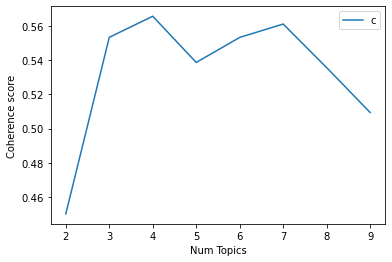

In [256]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [257]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4502
Num Topics = 3  has Coherence Value of 0.5532
Num Topics = 4  has Coherence Value of 0.5655
Num Topics = 5  has Coherence Value of 0.5386
Num Topics = 6  has Coherence Value of 0.5532
Num Topics = 7  has Coherence Value of 0.561
Num Topics = 8  has Coherence Value of 0.5355
Num Topics = 9  has Coherence Value of 0.5094


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [258]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [259]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('make', 0.05002655337227828),
   ('class', 0.03143919277748274),
   ('python', 0.027721720658523633),
   ('learn', 0.025597450876261287),
   ('clear', 0.024853956452469465),
   ('explanation', 0.020392989909718533),
   ('simple', 0.01975570897503983),
   ('cod', 0.019118428040361127),
   ('work', 0.01731279872543813),
   ('thing', 0.015932023366967606)]),
 (1,
  [('python', 0.2107183818162861),
   ('program', 0.11489938483995413),
   ('basic', 0.08017933479303514),
   ('start', 0.06474820143884892),
   ('language', 0.039724741945573974),
   ('programming', 0.037430924825357106),
   ('knowledge', 0.032843290584923364),
   ('recommend', 0.03200917526848087),
   ('learn', 0.023250964445834636),
   ('introduction', 0.02022729642373058)]),
 (2,
  [('beginner', 0.12076105204252938),
   ('easy', 0.09188584219362059),
   ('excellent', 0.09188584219362059),
   ('instructor', 0.06838276440962507),
   ('understand', 0.06435366536094013),
   ('explain', 0.04834918858421936),
   ('helpful'

In [270]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [271]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [272]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",course beginner enjoy learn dr chuck make huge...,"(0, 0.5088009)",0.0,0.508801
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",super easy totally beginner course title profe...,"(4, 0.7859078)",4.0,0.785908
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",interactive course start program pyhton,"(3, 0.75853324)",3.0,0.758533
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",awesome course definitely introduction cod wor...,"(3, 0.4024359)",3.0,0.402436
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",perfect new learner,"(4, 0.30848962)",4.0,0.308490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos,"[excellent, explanation, start, computer, gene...",excellent explanation start computer general w...,"(3, 0.513237)",3.0,0.513237
8828,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos,"[friend, recommanded, lecture, deserve, five, ...",friend recommanded lecture deserve five star rate,"(4, 0.44665098)",4.0,0.446651
8829,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos,"[highly, recommend, set, foundation, python]",highly recommend set foundation python,"(3, 0.48967525)",3.0,0.489675
8830,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos,"[best, python, program, course, absolute, begi...",best python program course absolute beginner,"(5, 0.41838634)",5.0,0.418386


In [273]:
df_final = df.drop(['joined', 'topic'], axis = 1)

In [285]:
df_final.head(51)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",0.0,0.508801
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",4.0,0.785908
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",3.0,0.758533
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",3.0,0.402436
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",4.0,0.308490
5,2021-03-11,It's an amazing course for the beginners.It is...,5,completer,208,pos,0.7906,pos,"[amaze, course, beginnersit, beginner, friendl...",5.0,0.512951
6,2021-03-11,\n\nGreat course and amazing teacher,5,completer,36,pos,0.8360,pos,"[course, amaze, teacher]",5.0,0.681456
7,2021-03-11,Challenging and perfect course for a beginner...,4,completer,262,pos,0.9403,pos,"[challenge, perfect, course, beginner, python,...",1.0,0.411996
8,2021-03-11,Good into to programming using this language,5,completer,44,pos,0.4404,pos,"[program, use, language]",3.0,0.676308
9,2021-03-11,BEST AS BEST,5,completer,12,pos,0.8555,pos,"[best, best]",5.0,0.605182


In [282]:
# Save dataframe as a csv file

df_final.to_csv('programming-for-everybody.csv')

In [288]:
df.loc[df['topic_id'] == 0.0].head(30)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos,"[course, beginner, enjoy, learn, dr, chuck, ma...",course beginner enjoy learn dr chuck make huge...,"(0, 0.5088009)",0.0,0.508801
12,2021-03-11,its really good for those who have zero knowle...,5,completer,91,pos,0.4927,pos,"[zero, knowledge, program, beginner]",zero knowledge program beginner,"(0, 0.5341389)",0.0,0.534139
34,2021-03-09,Amazing! A great start off with Python. Can't ...,5,completer,100,pos,0.8478,pos,"[amazing, start, python, cant, wait, continue,...",amazing start python cant wait continue course...,"(0, 0.46366525)",0.0,0.463665
38,2021-03-09,Chuck Sir is very inspiring and energetic. We ...,5,completer,88,pos,0.8503,pos,"[chuck, sir, inspire, energetic, interest, cou...",chuck sir inspire energetic interest course,"(0, 0.7987946)",0.0,0.798795
40,2021-03-09,Literally enjoyed every single video and learn...,5,completer,83,pos,0.8045,pos,"[literally, enjoy, every, single, video, learn...",literally enjoy every single video learnt much...,"(0, 0.7558453)",0.0,0.755845
42,2021-03-09,I learnt a lot,5,completer,14,pos,0.0000,neu,"[learnt, lot]",learnt lot,"(0, 0.580635)",0.0,0.580635
43,2021-03-08,One of the best course from coursera ..!! I ...,5,completer,205,pos,0.9514,pos,"[best, course, coursera, get, learn, many, ski...",best course coursera get learn many skill cour...,"(0, 0.44796652)",0.0,0.447967
47,2021-03-08,Fantastic,5,completer,9,pos,0.5574,pos,[fantastic],fantastic,"(0, 0.46426982)",0.0,0.464270
48,2021-03-08,That's great to learn sir.,4,completer,26,pos,0.6249,pos,"[thats, learn, sir]",thats learn sir,"(0, 0.44723204)",0.0,0.447232
54,2021-03-08,"Honestly, I learned a lot. Dr. Charles Severan...",5,completer,118,pos,0.9153,pos,"[honestly, learn, lot, dr, charles, severance,...",honestly learn lot dr charles severance teache...,"(0, 0.5168886)",0.0,0.516889


In [277]:
df.loc[df['topic_id'] == 1.0]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
7,2021-03-11,Challenging and perfect course for a beginner...,4,completer,262,pos,0.9403,pos,"[challenge, perfect, course, beginner, python,...",challenge perfect course beginner python aweso...,"(1, 0.4119964)",1.0,0.411996
20,2021-03-10,Good start for beginners!!! Thanks to Coursera...,4,completer,77,pos,0.7887,pos,"[start, beginner, thank, coursera, university,...",start beginner thank coursera university michigan,"(1, 0.5504484)",1.0,0.550448
33,2021-03-09,I am grateful to Prof. Charles Russell Severan...,5,completer,386,pos,0.9402,pos,"[grateful, prof, charles, russell, severance, ...",grateful prof charles russell severance start ...,"(1, 0.4080479)",1.0,0.408048
35,2021-03-09,It's Great!!!I love it!!!,5,completer,25,pos,0.7482,pos,[greati],greati,"(1, 0.46404424)",1.0,0.464044
60,2021-03-08,Awesome,5,completer,7,pos,0.6249,pos,[awesome],awesome,"(1, 0.46428418)",1.0,0.464284
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8768,2020-07-21,"Thanks for the course, was great!!",5,completer,34,pos,0.8217,pos,"[thanks, course]",thanks course,"(1, 0.4926408)",1.0,0.492641
8791,2020-07-21,thanks for the good work you gave to us thanks...,5,dropout,59,pos,0.9169,pos,"[thanks, work, give, u, thanks]",thanks work give u thanks,"(1, 0.6311388)",1.0,0.631139
8798,2020-07-21,"Thanks for the course, was great!!",5,dropout,34,pos,0.8217,pos,"[thanks, course]",thanks course,"(1, 0.4929214)",1.0,0.492921
8824,2020-07-21,Well -crafted course,5,dropout,21,pos,0.2732,pos,"[craft, course]",craft course,"(1, 0.49449995)",1.0,0.494500


In [278]:
df.loc[df['topic_id'] == 2.0]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
13,2021-03-11,"This was my first online class, and I truly en...",5,completer,156,pos,0.8357,pos,"[first, online, class, truly, enjoy, engage, m...",first online class truly enjoy engage manage f...,"(2, 0.35032737)",2.0,0.350327
16,2021-03-10,Good stuff,5,completer,10,pos,0.4404,pos,[stuff],stuff,"(2, 0.45533222)",2.0,0.455332
24,2021-03-10,"I think this class was awesome and, despite it...",5,completer,133,pos,0.8883,pos,"[think, class, awesome, despite, online, cours...",think class awesome despite online course lear...,"(2, 0.29551613)",2.0,0.295516
30,2021-03-10,Easy to understand. Just the right amount of c...,5,completer,170,pos,0.7531,pos,"[easy, understand, right, amount, challenge, l...",easy understand right amount challenge learn l...,"(2, 0.4283187)",2.0,0.428319
37,2021-03-09,\nExceptional\n\n,5,completer,14,pos,0.0000,neu,[exceptional],exceptional,"(2, 0.46426335)",2.0,0.464263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8788,2020-07-21,good work in good time,5,completer,22,pos,0.7003,pos,"[work, time]",work time,"(2, 0.602411)",2.0,0.602411
8804,2020-07-21,The videos are really good,5,dropout,26,pos,0.4927,pos,[video],video,"(2, 0.46336147)",2.0,0.463361
8813,2020-07-21,"please, i did not receive my certification",5,completer,42,pos,0.3182,pos,"[please, receive, certification]",please receive certification,"(2, 0.45496485)",2.0,0.454965
8814,2020-07-21,"please, i did not receive my certification",5,dropout,42,pos,0.3182,pos,"[please, receive, certification]",please receive certification,"(2, 0.45496875)",2.0,0.454969


In [279]:
df.loc[df['topic_id'] == 3.0]

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos,"[interactive, course, start, program, pyhton]",interactive course start program pyhton,"(3, 0.75853324)",3.0,0.758533
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos,"[awesome, course, definitely, introduction, co...",awesome course definitely introduction cod wor...,"(3, 0.4024359)",3.0,0.402436
8,2021-03-11,Good into to programming using this language,5,completer,44,pos,0.4404,pos,"[program, use, language]",program use language,"(3, 0.67630774)",3.0,0.676308
17,2021-03-10,"This was my first time in Coursera , I know ...",5,completer,278,pos,0.9624,pos,"[first, time, coursera, know, little, basic, p...",first time coursera know little basic python c...,"(3, 0.4658783)",3.0,0.465878
18,2021-03-10,Es war sehr hilfrich,5,completer,20,pos,-0.5994,neg,"[es, war, sehr, hilfrich]",es war sehr hilfrich,"(3, 0.73920447)",3.0,0.739204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,2020-07-21,A good course for those who aspire to build a ...,4,dropout,63,pos,0.4404,pos,"[course, aspire, build, career, python]",course aspire build career python,"(3, 0.35293356)",3.0,0.352934
8806,2020-07-21,"Gran curso, ahora comprendo el lenguaje python...",5,completer,109,pos,0.6249,pos,"[gran, curso, ahora, comprendo, el, lenguaje, ...",gran curso ahora comprendo el lenguaje python ...,"(3, 0.48537958)",3.0,0.485380
8822,2020-07-21,I was a beginner . i do not know anything abo...,5,dropout,184,pos,0.9132,pos,"[beginner, know, anything, python, learn, lot,...",beginner know anything python learn lot python...,"(3, 0.69856304)",3.0,0.698563
8827,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos,"[excellent, explanation, start, computer, gene...",excellent explanation start computer general w...,"(3, 0.513237)",3.0,0.513237


In [286]:
df.loc[df['topic_id'] == 4.0].head(30)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos,"[super, easy, totally, beginner, course, title...",super easy totally beginner course title profe...,"(4, 0.7859078)",4.0,0.785908
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos,"[perfect, new, learner]",perfect new learner,"(4, 0.30848962)",4.0,0.308490
10,2021-03-11,Great intro class for python,5,completer,28,pos,0.6249,pos,"[intro, class, python]",intro class python,"(4, 0.47979707)",4.0,0.479797
11,2021-03-11,It's really recommended,5,completer,23,pos,0.2716,pos,[recommend],recommend,"(4, 0.46171477)",4.0,0.461715
14,2021-03-11,This programming language is of the higher val...,5,completer,63,pos,0.3400,pos,"[program, language, high, value, u, learner]",program language high value u learner,"(4, 0.5374271)",4.0,0.537427
25,2021-03-10,Great introductory course to Python. Instructo...,5,completer,87,pos,0.7778,pos,"[introductory, course, python, instructor, eng...",introductory course python instructor engage l...,"(4, 0.5105292)",4.0,0.510529
26,2021-03-10,Highly recommended introductory course.,5,completer,39,pos,0.2716,pos,"[highly, recommended, introductory, course]",highly recommended introductory course,"(4, 0.69402707)",4.0,0.694027
29,2021-03-10,Course material is excellent and Instructor ha...,5,completer,81,pos,0.5719,pos,"[course, material, excellent, instructor, make...",course material excellent instructor make thin...,"(4, 0.55848676)",4.0,0.558487
51,2021-03-08,"As a first timer with code and programming, th...",5,completer,541,pos,0.9831,pos,"[first, timer, code, program, fun, thorough, i...",first timer code program fun thorough introduc...,"(4, 0.26788208)",4.0,0.267882
52,2021-03-08,Not satisfied with the course content.It was s...,1,completer,53,neg,-0.3252,neg,"[satisfied, course, contentit, basic]",satisfied course contentit basic,"(4, 0.47983536)",4.0,0.479835


In [287]:
df.loc[df['topic_id'] == 5.0].head(30)

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
5,2021-03-11,It's an amazing course for the beginners.It is...,5,completer,208,pos,0.7906,pos,"[amaze, course, beginnersit, beginner, friendl...",amaze course beginnersit beginner friendly cou...,"(5, 0.51295125)",5.0,0.512951
6,2021-03-11,\n\nGreat course and amazing teacher,5,completer,36,pos,0.8360,pos,"[course, amaze, teacher]",course amaze teacher,"(5, 0.68145555)",5.0,0.681456
9,2021-03-11,BEST AS BEST,5,completer,12,pos,0.8555,pos,"[best, best]",best best,"(5, 0.6051821)",5.0,0.605182
15,2021-03-10,Excellent Teaching!!........:),5,completer,30,pos,0.6467,pos,"[excellent, teaching]",excellent teaching,"(5, 0.6052595)",5.0,0.605259
19,2021-03-10,it is very helpful to me,5,completer,24,pos,0.4754,pos,[helpful],helpful,"(5, 0.44093972)",5.0,0.440940
23,2021-03-10,Great Course!,5,completer,13,pos,0.6588,pos,[course],course,"(5, 0.4491131)",5.0,0.449113
27,2021-03-10,Great Course.,5,completer,13,pos,0.6249,pos,[course],course,"(5, 0.4490894)",5.0,0.449089
28,2021-03-10,"excellent very good course, the teacher explai...",5,completer,59,pos,0.8514,pos,"[excellent, course, teacher, explains]",excellent course teacher explains,"(5, 0.5161)",5.0,0.516100
36,2021-03-09,"Awesome course , I will be happy if the course...",5,completer,254,pos,0.9393,pos,"[awesome, course, happy, course, somehow, avai...",awesome course happy course somehow available ...,"(5, 0.5342917)",5.0,0.534292
44,2021-03-08,One of the best courses with a great instructo...,5,completer,110,pos,0.9255,pos,"[best, course, instructor, explain, every, con...",best course instructor explain every concept s...,"(5, 0.85320663)",5.0,0.853207
